# SedGen testing

## Imports

In [1]:
import numpy as np
import numba as nb
from numba.typed import List
import numexpr as ne
import pandas as pd
import itertools
from operator import itemgetter
import gc
import copy

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [2]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing
from sedgen import geostatistics
from sedgen import visualization as viz
from sedgen.visualization import SedGenEvolution

In [3]:
%load_ext line_profiler
%load_ext memory_profiler

In [4]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

## Model input
___

### Parent rock characteristics

In [5]:
# Unit is mm³
parent_rock_volume = 1e9

# Mineral classes present in parent rock
minerals = ["Q", "P", "K", "B", "O", "A"]

### Modal mineralogy
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [6]:
# Modal mineralogy mean values f CA-NS of Heins(1992)
modal_mineralogy = np.array([0.30591989, 0.38159713, 0.26209888, 0.01882560, 0.00799247, 0.02356603])

### Interfacial composition
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [7]:
interface_proportions_true = None

### Crystal size distributions
This property will be based on a mean crystal size and standard deviation  
which will be represented as a log-normal distribution.

In [8]:
csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

## Initialization

In [9]:
# Create scenario data
balance = np.array([0.5] * 100)
climate = np.array([2] * 100)
# Keep additional input material limited to first couple of steps
# Otherwise this has a massive performance impact regarding the time it
# takes for the model to execute due to very high number of pcgs/mcgs.
# new_input = np.array([0.01] * 10 + [0.0] * 90)
new_input = np.array([0.00] * 100)
scenario_array = np.stack([balance, climate, new_input], axis=1)

In [10]:
%%time
sedgen_CA_NS = SedGen(minerals, 
                      parent_rock_volume, 
                      modal_mineralogy,
                      csds_CA_NS_means, 
                      csds_CA_NS_stds, 
                      scenario_data=scenario_array,
                      learning_rate=10000, 
                      timed=True,
                      chem_weath_rates=[0.01, 0.13, 0.07, 0.05, 0.01, 0.03])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.6443 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.8365 seconds
Counting interfaces...  Done in 0.0349 seconds
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2390 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
Wall time: 31.8 s


___

In [11]:
%%time
sedgen_CA_NS_mech = \
    sedgen_CA_NS.weathering(
        operations=["intra_cb", "inter_cb"], 
        steps=100, inplace=False,
        display_mass_balance=False)

After 81 steps all pcgs have been broken down to mcg
Wall time: 1min 44s


In [12]:
%time sedgen_CA_NS_mech_evolution = SedGenEvolution(sedgen_CA_NS_mech, 0, 100, 5, 25)

Starting calculation of volumes' evolution of model from step 0 to step 100 with a 5 step(s) interval.
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Calculating pcg_volumes_evolution of sedgen model...
All 17 steps accounted for.
Calculating mcg_volumes_evolution of sedgen model...
Calculating residue_volumes_evolution of sedgen model...
Done.
Wall time: 1min 38s


In [78]:
%time sedgen_CA_NS_mech_evolution_10 = SedGenEvolution(sedgen_CA_NS_mech, 0, 100, 10)

Starting calculation of volumes' evolution of model from step 0 to step 100 with a 10 step(s) interval.
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
Calculating pcg_volumes_evolution of sedgen model...
Calculating mcg_volumes_evolution of sedgen model...
Calculating residue_volumes_evolution of sedgen model...
Done.
Wall time: 48.5 s


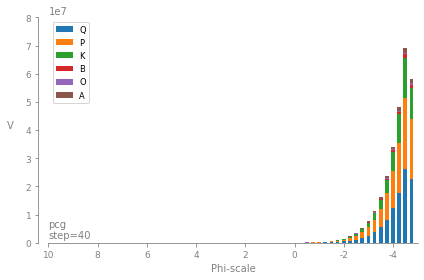

In [167]:
sedgen_CA_NS_mech_evolution.grain_size_barplot(8, 'pcg')

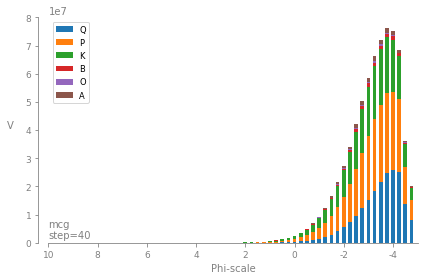

In [211]:
sedgen_CA_NS_mech_evolution.grain_size_barplot(8, 'mcg')

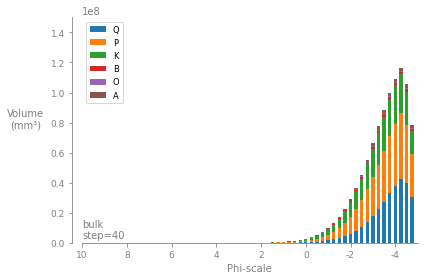

In [222]:
sedgen_CA_NS_mech_evolution.grain_size_barplot(8, 'bulk', volume_limit=1.5e8, save_filename="mech_100_chem_0")

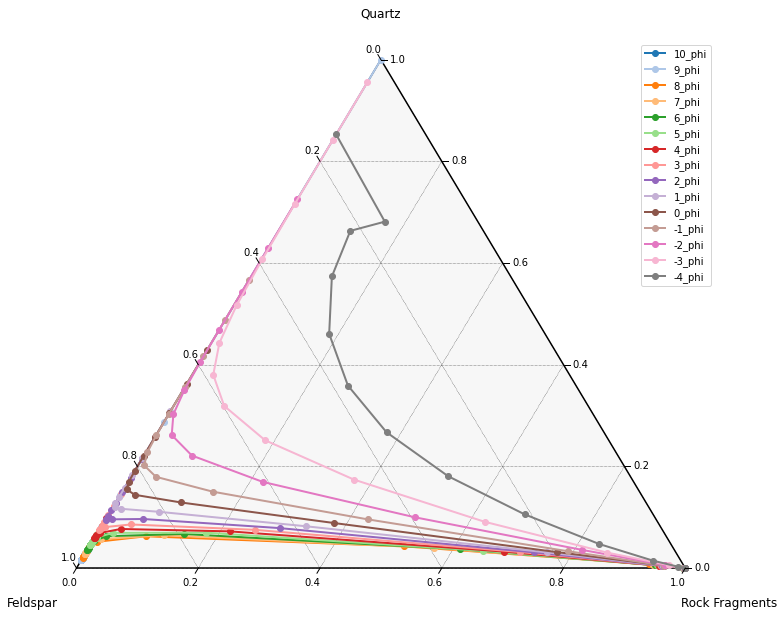

In [99]:
sedgen_CA_NS_mech_evolution.QFR_ternary_plot(save_filename="mech_100_chem_0")

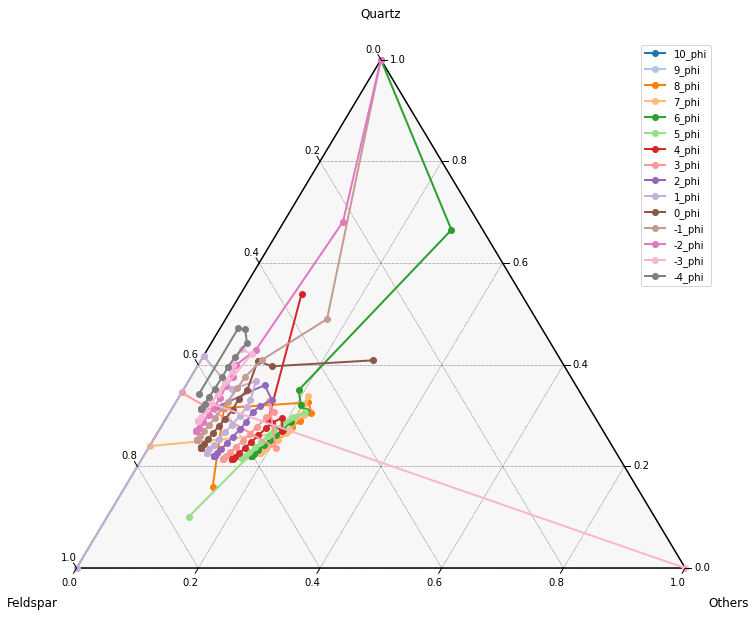

In [100]:
sedgen_CA_NS_mech_evolution.QFOth_ternary_plot(save_filename="mech_100_chem_0")

___

Examples of duration for new material input with only mechanical weathering:
- 10% new material every step out of 100 steps: 11m30s
- 10% new material for first 10 steps out of 100 steps: 4m58s
- 1% new material for first 10 steps out of 100 steps: 2m10s
- no new input: 1m58s

In [ ]:
%%time
sedgen_CA_NS = SedGen(minerals, 
                      parent_rock_volume, 
                      modal_mineralogy,
                      csds_CA_NS_means, 
                      csds_CA_NS_stds, 
                      scenario_data=scenario_array,
                      learning_rate=10000, 
                      timed=True,
                      chem_weath_rates=[0.01, 0.13, 0.07, 0.05, 0.01, 0.03])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 3.5931 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.8629 seconds
Counting interfaces...  Done in 0.0361 seconds
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2268 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...


In [106]:
%%time
sedgen_CA_NS_chem = \
    sedgen_CA_NS.weathering(
        operations=["chem_mcg", "chem_pcg"], 
        steps=100, inplace=False)

Wall time: 29.3 s


In [107]:
%time sedgen_CA_NS_chem_evolution = SedGenEvolution(sedgen_CA_NS_chem, 0, 100, 5)

Starting calculation of volumes' evolution of model from step 0 to step 100 with a 5 step(s) interval.
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Calculating pcg_volumes_evolution of sedgen model...
Calculating mcg_volumes_evolution of sedgen model...3 02 3 1 30 2 3 4 5 12 1 3 4 5
Calculating residue_volumes_evolution of sedgen model...
Done.
Wall time: 5.85 s


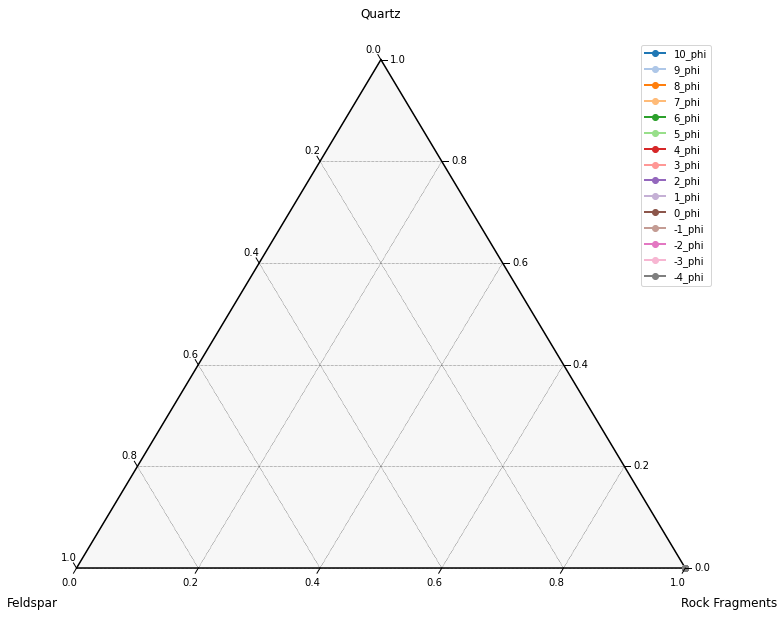

In [108]:
sedgen_CA_NS_chem_evolution.QFR_ternary_plot(save_filename="mech_0_chem_100")

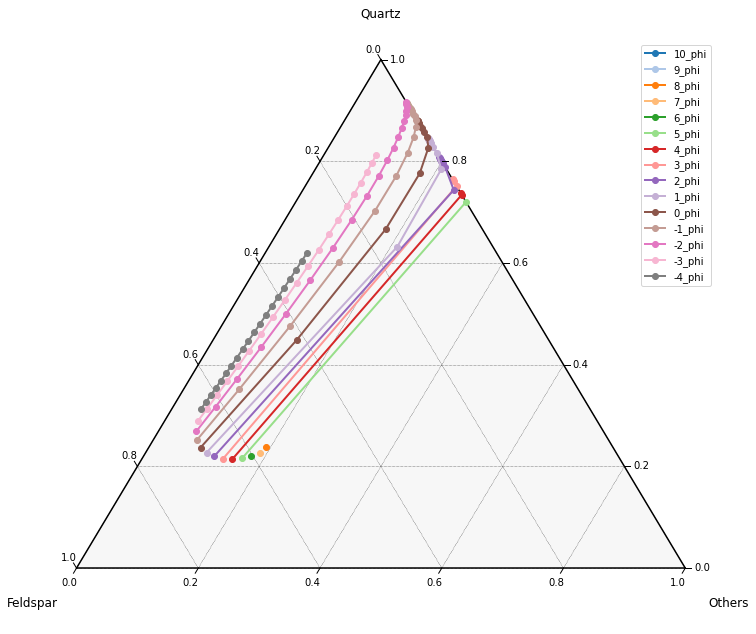

In [109]:
sedgen_CA_NS_chem_evolution.QFOth_ternary_plot(save_filename="mech_0_chem_100")

Examples of duration for new material input with only chemical weathering:
- 10% new material every step out of 100 steps: not checked
- 10% new material for first 10 steps out of 100 steps: not checked
- 1% new material for first 10 steps out of 100 steps: 37.8s
- no new input: 24s

d:\box sync\programming\python\jupyter_notebooks\sedgen\sedgen\src\sedgen\visualization.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(sedgenmech.mcg_additions), label="mcg", lw=2)


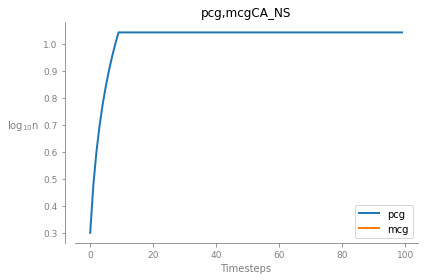

In [16]:
viz.lineplotpcgmcg("CA_NS", sedgen_CA_NS_chem, "test")

In [12]:
%%time
sedgen_CA_NS_both = \
    sedgen_CA_NS.weathering(
    operations=["intra_cb", "inter_cb", 
                "chem_mcg", "chem_pcg"], 
    steps=100, inplace=False)

After 70 steps all pcgs have been broken down to mcg
Wall time: 1min 48s


Examples of duration for new material input with both types of weathering:
- 10% new material every step out of 100 steps: not checked
- 10% new material for first 10 steps out of 100 steps: not checked
- 1% new material for first 10 steps out of 100 steps: 2m19s
- no new input: 1m06s

___